In [420]:
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import json

In [421]:
G=nx.Graph()

In [422]:
df = pd.read_csv("https://raw.githubusercontent.com/umassdgithub/Week-7-ForceLayout/main/data/data_scopus.csv")
pd.set_option("max_rows", None)
df.head(5)

,Title,Year,EID,Abstract,Publisher,Conference name,Conference date,Authors,Author(s) ID,Authors with affiliations,Source title,Abbreviated Source Title,Cited by
0,Virtual reality applications for the built env...,2020,2-s2.0-85086464158,With its advanced capabilities of immersive an...,Elsevier B.V.,NaN,NaN,"Zhang Y., Liu H., Kang S.-C., Al-Hussein M.",57202536919;53984550800;57215426514;6603541102;,"Zhang, Y., Department of Civil and Environment...",Automation in Construction,Autom Constr,NaN
1,"Self-tracking while doing sport: Comfort, moti...",2020,2-s2.0-85082875828,The spread of wearable technologies is paving ...,Academic Press,NaN,NaN,"Rapp A., Tirabeni L.",23398572100;57191836654;,"Rapp, A., Computer Science Department, Univers...",International Journal of Human Computer Studies,Int J Hum Comput Stud,NaN
2,"Bridge damage: Detection, IFC-based semantic e...",2020,2-s2.0-85078194587,Building Information Modeling (BIM) representa...,Elsevier B.V.,NaN,NaN,"Isailović D., Stojanovic V., Trapp M., Richter...",57205293410;56421700900;24831175200;3619515940...,"Isailović, D., Department for Construction Pro...",Automation in Construction,Autom Constr,NaN
3,VR system for spatio-temporal visualization of...,2019,2-s2.0-85075706132,Social media analysis is helpful to understand...,Springer,NaN,NaN,"Okada K., Yoshida M., Itoh T., Czauderna T., S...",57201502480;57171240600;35373203100;2592569550...,"Okada, K., Ochanomizu University, Tokyo, Japan...",Multimedia Tools and Applications,Multimedia Tools Appl,NaN
4,DiseaSE: A biomedical text analytics system fo...,2019,2-s2.0-85074886243,Due to increasing volume and unstructured natu...,Academic Press Inc.,NaN,NaN,"Abulaish M., Parwez M.A., Jahiruddin",6505934038;57202719622;35590173900;,"Abulaish, M., Department of Computer Science, ...",Journal of Biomedical Informatics,J. Biomed. Informatics,NaN


## Example: articles are the nodes, and having co-authorship, links them to each other (edges)

In [423]:
nodes = df['Publisher'].values ## value of the DOIs (unique paper ids)

In [424]:
nodes = df['Publisher'].values ## value of the publishers for nodes
nodes = [n for n in nodes if str(n) != 'nan'] # Remove 'nans'       

edges = []
edge_weights = []

## Get all author IDs for each paper
authors = []
for row in df.iterrows(): ## iterate over the table rows
    author = row[1]['Author(s) ID'].split(";"); ## author ids for each row are separated using a semicolon(;)
    while("" in author): ## clean data by removing empty author data
        author.remove("")
    authors.append(author) # append each row of authors to authors

    
# For each author ID if another paper with a different publisher shares the same ID,
# append a tuple of both publishers (nodes) to an edge
current_pub = ""
for index, author in enumerate(authors):
    current_pub = df["Publisher"][index]
    for auth_id in author:
        for i in range(index, len(df)):
            pub = df["Publisher"][i]
            if current_pub != pub and auth_id in df['Author(s) ID'][i] and not pd.isna(current_pub) and not pd.isna(pub): # Ensure publishers are not the same and remove all NaN values
                # Increment edge weights for each edge that already exists
                if (current_pub, pub) in edges:
                    edge_weights[edges.index((current_pub, pub))] +=1
                # Increment edge weights for each edge that already exists
                if (pub, current_pub) in edges:
                    edge_weights[edges.index((pub, current_pub))] +=1
                # Ensure the edge does not already exist in edges
                if (current_pub, pub) not in edges and (pub, current_pub) not in edges:   
                    edges.append((current_pub, pub))
                    edge_weights.append(1)



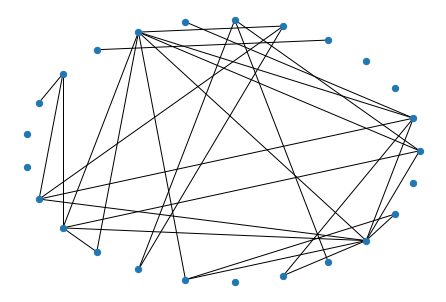

In [425]:
#--Create/draw the graph--

# Add nodes to graph
G.add_nodes_from(nodes)
# Add edges to graph
G.add_edges_from(edges)
pos = nx.drawing.circular_layout(G)
# Draw
nx.draw(G, pos=pos, node_size=40) 


In [426]:
#  Creating and writing JSON object to file to build D3 Network:
#  Add 'group' attribute to nodes, convert edges from strings to 
#  integers and add edge weights

# Filename to write to
file = "./publication_network.json"
    
# Create file, format the data object, and write to json file
with open(file,'w') as f:
    obj = nx.readwrite.json_graph.node_link_data(G)
    # Remove unnecc data from obj
    obj.pop("directed")
    obj.pop("multigraph")
    obj.pop("graph")
    
    # Add 'group' attribute to each node, set value to 1
    for n in obj['nodes']:
        n['group'] = 1
        
    # Create a key:value dic obj to associate each publisher name node (string) to an ID No. (integer) 
    dic = {}
    i = 0
    for n in obj['nodes']:
        dic[n['id']] = i
        i+=1
    
    # Convert each edge string name to integer values
    i = 0
    for e in obj['links']:
        source_int = dic[e['source']]
        target_int = dic[e['target']]
        e['source'] = source_int
        e['target'] = target_int
        # Add associated 'weight' attribute for each edge
        e['weight'] = edge_weights[i]
        i += 1 
    
    # Write JSON object to file
    json.dump(obj,f)

obj

{'nodes': [{'id': 'Elsevier B.V.', 'group': 1},
  {'id': 'Academic Press', 'group': 1},
  {'id': 'Springer', 'group': 1},
  {'id': 'Academic Press Inc.', 'group': 1},
  {'id': 'Institute of Physics Publishing', 'group': 1},
  {'id': 'Elsevier Ltd', 'group': 1},
  {'id': 'Springer New York LLC', 'group': 1},
  {'id': 'Taylor and Francis Inc.', 'group': 1},
  {'id': 'Society for Imaging Science and Technology', 'group': 1},
  {'id': 'International Multidisciplinary Scientific Geoconference',
   'group': 1},
  {'id': 'Association for Computing Machinery', 'group': 1},
  {'id': 'Institute of Electrical and Electronics Engineers Inc.', 'group': 1},
  {'id': 'BioMed Central Ltd.', 'group': 1},
  {'id': 'IADIS', 'group': 1},
  {'id': 'IEEE Computer Society', 'group': 1},
  {'id': 'Elsevier', 'group': 1},
  {'id': 'Kluwer Academic Publishers', 'group': 1},
  {'id': 'Springer Verlag', 'group': 1},
  {'id': 'IEEE, Piscataway, NJ, United States', 'group': 1},
  {'id': 'Elsevier Science B.V., Amst